In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import keras
import pandas as pd
import math
import joblib

from IPython.display import display

Using TensorFlow backend.


# Load Models

In [2]:
generator_path = "saved_models/generator.hdf5"
generator = keras.models.load_model(generator_path)

/home/brian/anaconda3/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# Need to re-include loss functions so model knows how to load them
def kl_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.sum(1. + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
   
    return K.mean(kl_loss)

def logx_loss(x, x_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(_x_decoded_var + var_epsilon)
            + 0.5 * K.square(x - x_decoded_mean) / (_x_decoded_var + var_epsilon))
    loss = K.sum(loss, axis=-1)
    return K.mean(loss)

def vae_loss(x, x_decoded_mean):
    return logx_loss(x, x_decoded_mean) + kl_loss(x, x_decoded_mean)

vae_path = "saved_models/vae.hdf5"
vae = keras.models.load_model(vae_path, custom_objects={'vae_loss': vae_loss}, compile=False)

In [4]:
pca_model_file = 'saved_models/pca_1000.pkl'
pca = joblib.load(pca_model_file)
n_components = pca.n_components_
pca

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Sample Some Random Images

In [5]:
digit_size = 32
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 512

Using the generator network (decoder), we'll sample some from our isotropic standard Gaussians and generate a grid of 10x10 images.

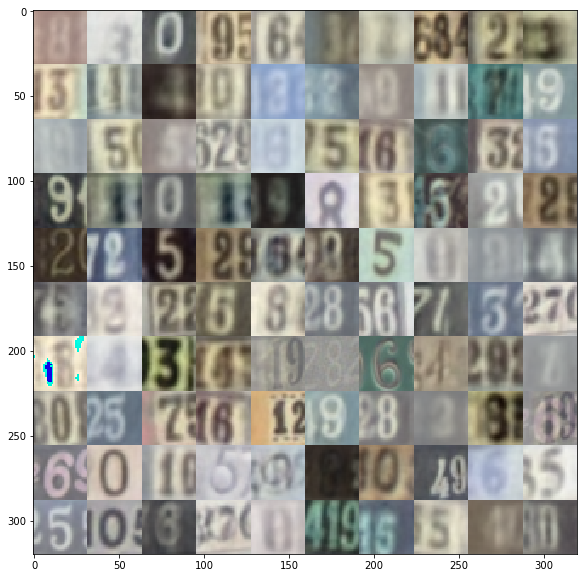

In [6]:
n = 10
figure = np.zeros((digit_size * n, digit_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        x_recon = pca.inverse_transform(x_decoded)
        x_recon *= 255.
        digit = x_recon.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit.astype(int)
 
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Definitely a bit blurry but definitely some good images that came out.  It's not so bad when you remember the originals had many blurry images too.

# VAE Analogies

For analogies, we'll take one of the images from our original sample and then pump it through the entire VAE pipeline.  Under the hood, the network should estimate the latent mean and variance for that sample, and then use the generator network to decode it into a "similar" looking image that sampled from our shifted/scaled latent Gaussian random variable.

In [7]:
f = h5py.File("../../data/svhn/svhn_format_2.hdf5", "r")
X_dataset, y_dataset = list(f.items())

# Use a nice round number divisible by our batch size
N=630000

X_dataset, y_dataset = np.moveaxis(X_dataset[1][:N], 1, 3), y_dataset[1][:N]
print ("Full Dataset - DType X=%s, y=%s" % (X_dataset.dtype, y_dataset.dtype))
print ("Full Dataset - Shape X=%s, y=%s" % (X_dataset.shape, y_dataset.shape))

Full Dataset - DType X=uint8, y=uint8
Full Dataset - Shape X=(630000, 32, 32, 3), y=(630000, 1)


In [8]:
def random_image(digit):
    assert 0 <= digit <= 9
    while True:
        index = np.random.randint(0, len(X_dataset))
        if y_dataset[index] == digit:
            return X_dataset[index]

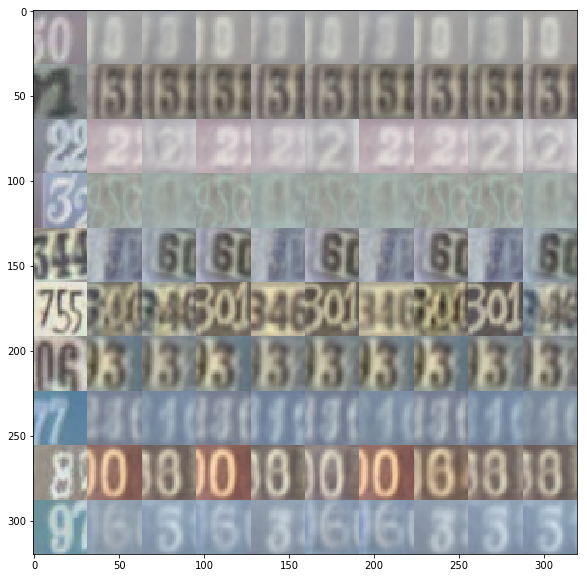

In [9]:
batch_size = 1000
figure = np.zeros((digit_size * 10, digit_size * 10, img_chns))

for i in range(0, 10):
    image = random_image(i)
    
    # Create batch to send through our network
    X_sample = np.stack([image] * 1000)
    batch = pca.transform(X_sample.reshape(batch_size, -1) / 255.)
    x_decoded = vae.predict(batch, batch_size=batch_size)
    
    # Convert back to RGB format
    x_recon = pca.inverse_transform(x_decoded)
    x_recon *= 255.
    analogue = x_recon.reshape(batch_size, digit_size, digit_size, img_chns)

    # First column is our original imge
    d_x = i * digit_size
    d_y = 0
    figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = image.astype(int)
    last = [image]
   
    # Rest of the columns are analogies, attempting to select ones that are different
    for j in range(1, 10):
        d_x = i * digit_size
        d_y = j * digit_size
        best_val = 0
        best_img = None
        for k in range(j * 100, (j + 1) * 100):
            val = np.mean([np.abs(l - analogue[k]).mean() for l in last])
            if val >= best_val:
                best_val = val
                best_img = analogue[k]
                
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = best_img.astype(int)
        last.append(best_img)

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Analogies aren't exactly what I thought they would be.  I was expecting to see rows of "1"s, "2"s etc. or even similar colours and styles across the rows.  Some have similarities (in terms of colour or number), while others seem way off.  It's kind of hard to tell if we're doing the right thing because we've transformed into PCA space, so it's much harder to interpret what's going on.  Additionally, I suspect the way I've encoded the output variance allows a "generous" deviation from the actual source image, perhaps resulting in the wide variation.